# Импорт библиотек

In [101]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, balanced_accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN



rs = random_state = 123
np.random.seed(1)

In [2]:
np.random.randint(10)

5

# Создание датасета

In [3]:
df0 = pd.DataFrame({'x1': np.random.normal(0, 7, 5000), 'x2': np.random.normal(0, 7, 5000), 'y': 0})
df1 = pd.DataFrame({'x1': np.random.normal(10, 7, 500), 'x2': np.random.normal(10, 7, 500), 'y': 1})
df = pd.concat([df0, df1], axis=0).sample(frac=1)

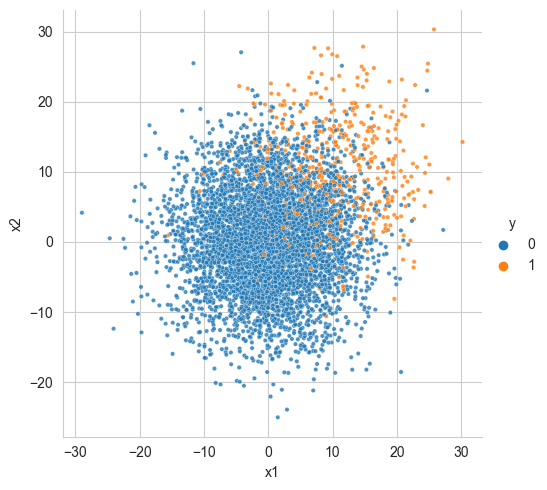

In [4]:
sns.relplot(data=df, x='x1', y='x2', hue='y', alpha=0.8, s=10);
plt.xlabel('x1')
plt.ylabel('x2');

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('y', axis=1), df['y'], test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [6]:
x_val.shape

(880, 2)

# Бейзлайн

Для начала создадим собственную метрику, учитывающую стоимость ошибок первого и второго рода

In [7]:
def costs(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tn*1500-fn*5000) / y_true.shape[0]
cost_function = make_scorer(costs, greater_is_better=True)

Напишем функцию, чтобы подбирать порог бинаризации на обучающей выборке и применять его к валидационной.

In [111]:
def func(model, x_train, y_train, x_val, y_val, specialty=''):

    model.fit(x_train, y_train)
    train_proba = model.predict_proba(x_train)[:, 1]
    train_res = [costs(y_train, train_proba>thr) for thr in train_proba]
    train_thr_opt = train_proba[np.argmax(train_res)]

    val_proba = model.predict_proba(x_val)[:, 1]
    val_res = [costs(y_val, val_proba>thr) for thr in val_proba]
    val_thr_opt = val_proba[np.argmax(val_res)]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    # fig.tight_layout()

    plt.suptitle(f'{model.__class__.__name__} + {specialty}')
    sns.scatterplot(x=x_train.iloc[:, 0], y=x_train.iloc[:, 1], hue=y_train, ax=ax1)
    ax1.set_title('Обучающая выборка')
    sns.scatterplot(x=train_proba, y=train_res, ax=ax2)
    ax2.set_title('Подбор порога в обучающей выборке')
    ax2.axvline(train_thr_opt)

    ax2.set_xlabel('threshold')
    ax2.set_ylabel('costs_score')


    sns.scatterplot(x=x_val.iloc[:, 0], y=x_val.iloc[:, 1], hue=y_val, ax=ax3)
    ax3.set_title('Валидационная выборка')
    sns.scatterplot(x=val_proba, y=val_res, ax=ax4)
    ax4.set_title('Применение порога к валидационной выборке')
    ax4.axvline(train_thr_opt)
    ax4.axvline(val_thr_opt, linestyle=':')
    ax4.set_xlabel('threshold')
    ax4.set_ylabel('costs_score')

    print(f' Порог для costs: {train_thr_opt:.2f}',
          f'\n costs на обучающей выборке: {costs(y_train, train_proba>train_thr_opt):.0f}',
          f'\n costs на валидационной выборке: {costs(y_val, val_proba>train_thr_opt):.0f}',
          f'\n\t accuracy на обучающей выборке: {accuracy_score(y_train, train_proba>0.5):.4f}',
          f'\n\t accuracy на валидационной выборке: {accuracy_score(y_val, val_proba>0.5):.4f}',
          f'\n balanced_accuracy на обучающей выборке: {balanced_accuracy_score(y_train, train_proba>0.5):.4f}',
          f'\n balanced_accuracy на валидационной выборке: {balanced_accuracy_score(y_val, val_proba>0.5):.4f}',
          f'\n\t recall на обучающей выборке: {recall_score(y_train, train_proba>0.5):.4f}',
          f'\n\t recall на валидационной выборке: {recall_score(y_val, val_proba>0.5):.4f}',
          f'\n precision на обучающей выборке: {precision_score(y_train, train_proba>0.5):.4f}',
          f'\n precision на валидационной выборке: {precision_score(y_val, val_proba>0.5):.4f}',
          f'\n\t f1-score на обучающей выборке: {f1_score(y_train, train_proba>0.5):.4f}',
          f'\n\t f1-score на валидационной выборке: {f1_score(y_val, val_proba>0.5):.4f}',
          f'\n roc-auc на обучающей выборке: {roc_auc_score(y_train, train_proba>0.5):.4f}',
          f'\n roc-auc на валидационной выборке: {roc_auc_score(y_val, val_proba>0.5):.4f}'

          )


Применим функцию к исходным данным

 Порог для costs: 0.21 
 costs на обучающей выборке: 1145 
 costs на валидационной выборке: 1086 
	 accuracy на обучающей выборке: 0.9364 
	 accuracy на валидационной выборке: 0.9216 
 balanced_accuracy на обучающей выборке: 0.7019 
 balanced_accuracy на валидационной выборке: 0.6545 
	 recall на обучающей выборке: 0.4175 
	 recall на валидационной выборке: 0.3253 
 precision на обучающей выборке: 0.7457 
 precision на валидационной выборке: 0.6750 
	 f1-score на обучающей выборке: 0.5353 
	 f1-score на валидационной выборке: 0.4390 
 roc-auc на обучающей выборке: 0.7019 
 roc-auc на валидационной выборке: 0.6545


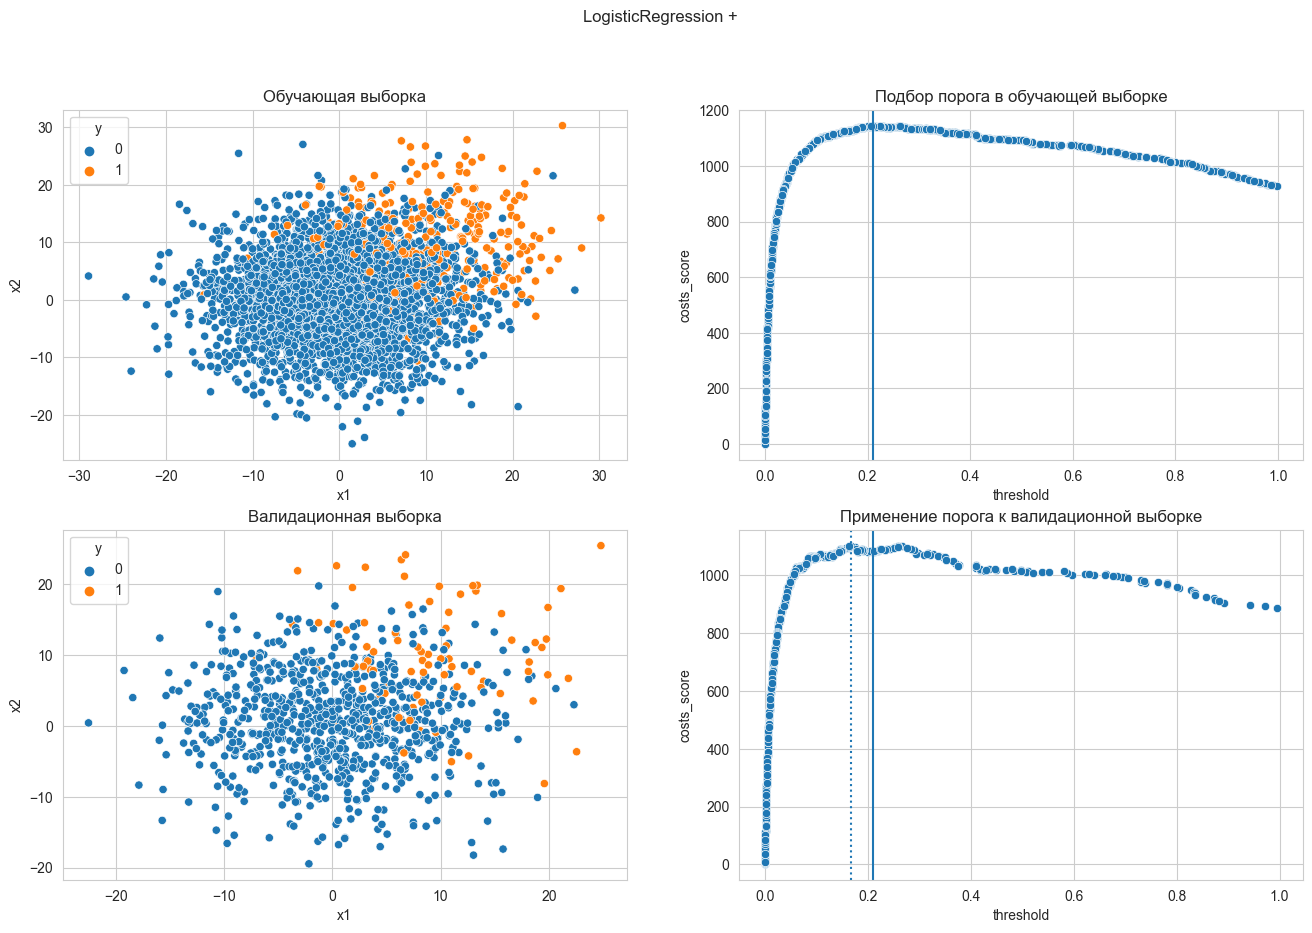

In [112]:
func(LogisticRegression(), x_train, y_train, x_val, y_val)

# class_weight='balanced'

 Порог для costs: 0.74 
 costs на обучающей выборке: 1144 
 costs на валидационной выборке: 1084 
	 accuracy на обучающей выборке: 0.8355 
	 accuracy на валидационной выборке: 0.8432 
 balanced_accuracy на обучающей выборке: 0.8338 
 balanced_accuracy на валидационной выборке: 0.8325 
	 recall на обучающей выборке: 0.8317 
	 recall на валидационной выборке: 0.8193 
 precision на обучающей выборке: 0.3278 
 precision на валидационной выборке: 0.3560 
	 f1-score на обучающей выборке: 0.4703 
	 f1-score на валидационной выборке: 0.4964 
 roc-auc на обучающей выборке: 0.8338 
 roc-auc на валидационной выборке: 0.8325


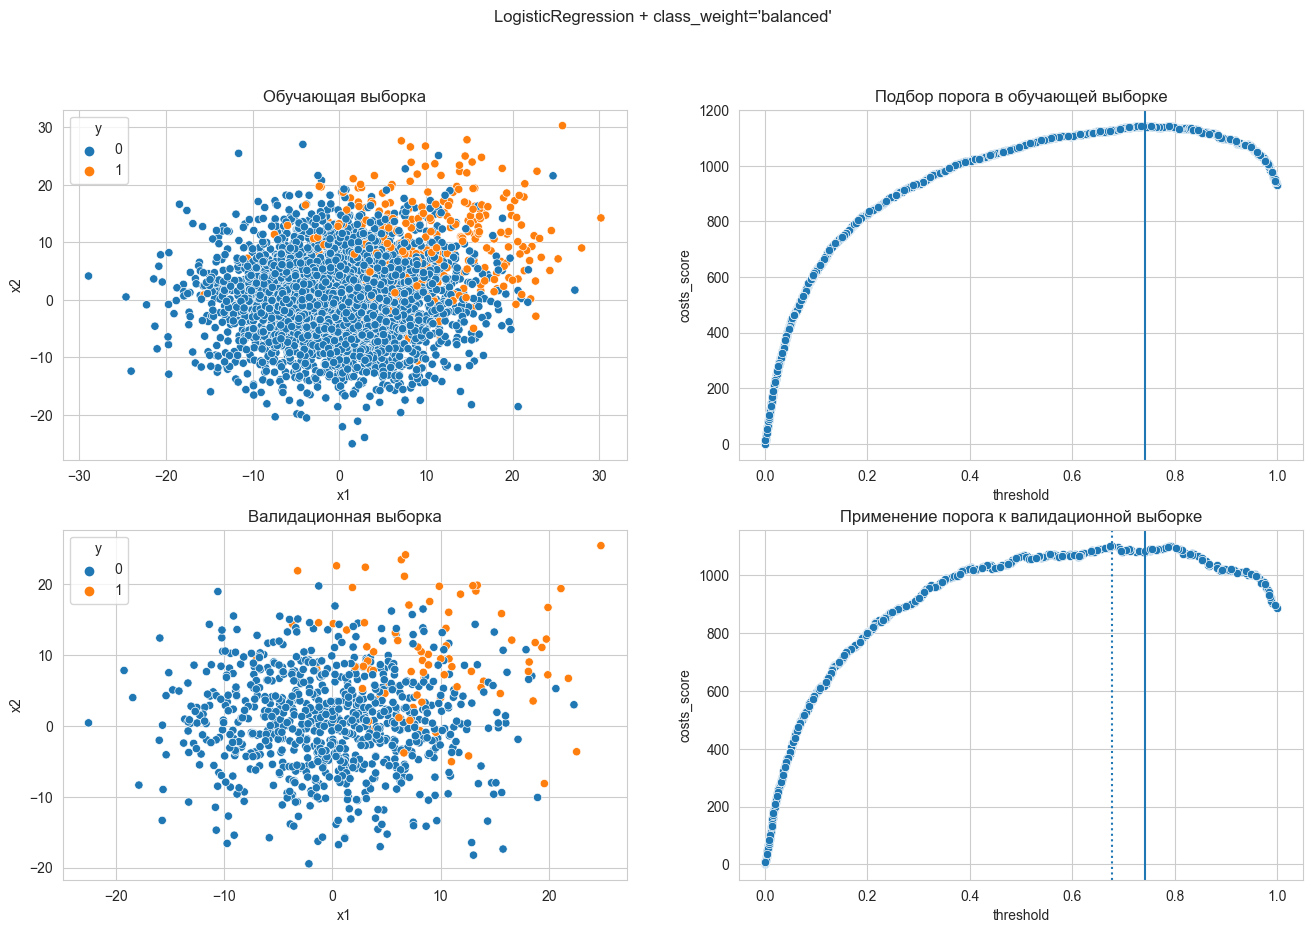

In [113]:
func(LogisticRegression(class_weight='balanced'), x_train, y_train, x_val, y_val, specialty="class_weight='balanced'")

Метрика не изменилась, но сильно поменялся порог

# SMOTE

In [116]:
smote = SMOTE(random_state=rs)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

 Порог для costs: 0.18 
 costs на обучающей выборке: 403 
 costs на валидационной выборке: 769 
	 accuracy на обучающей выборке: 0.8304 
	 accuracy на валидационной выборке: 0.8432 
 balanced_accuracy на обучающей выборке: 0.8304 
 balanced_accuracy на валидационной выборке: 0.8325 
	 recall на обучающей выборке: 0.8272 
	 recall на валидационной выборке: 0.8193 
 precision на обучающей выборке: 0.8326 
 precision на валидационной выборке: 0.3560 
	 f1-score на обучающей выборке: 0.8299 
	 f1-score на валидационной выборке: 0.4964 
 roc-auc на обучающей выборке: 0.8304 
 roc-auc на валидационной выборке: 0.8325


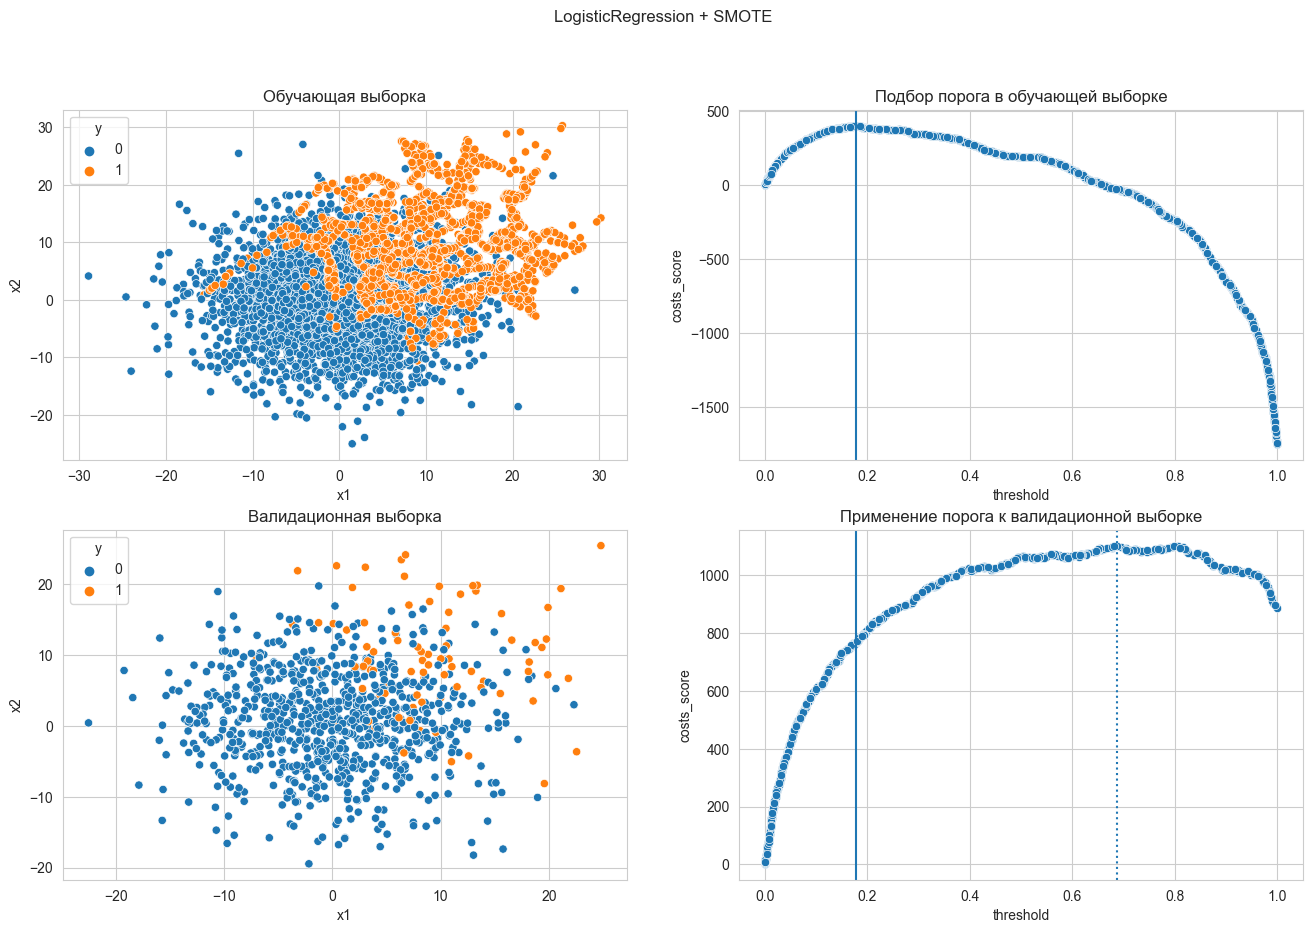

In [117]:
func(LogisticRegression(), x_train_smote, y_train_smote, x_val, y_val, specialty='SMOTE')

ВСе плохо. Кстати, class_weight='balanced' никак не влияет на сбалансированные датасеты

# ADASYN

In [98]:
adasyn = ADASYN(random_state=rs)
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train, y_train)

Порог: 0.27 
Обучающая выборка: 347 
Валидационная выборка: 786


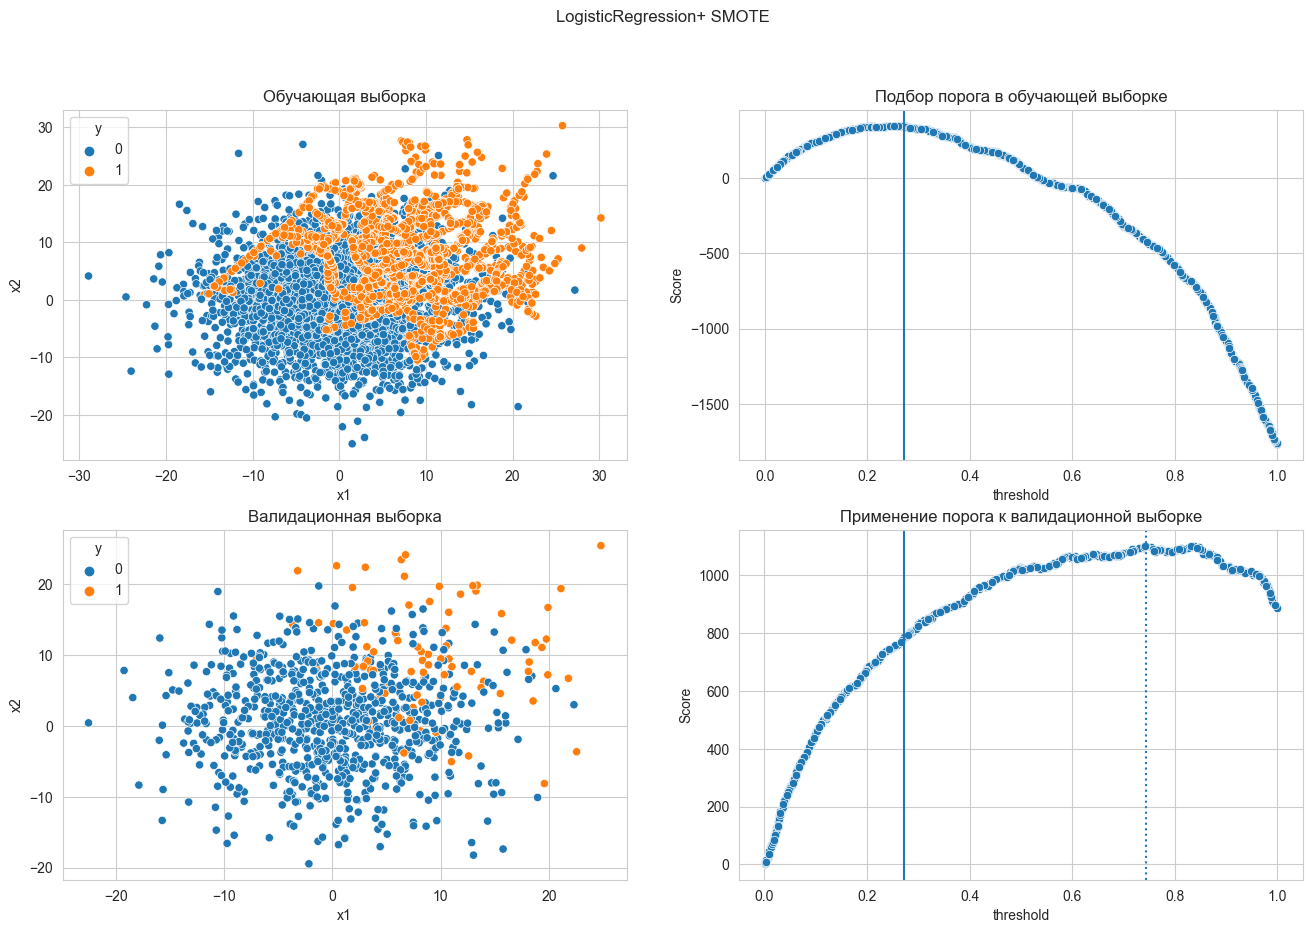

In [99]:
func(LogisticRegression(), x_train_adasyn, y_train_adasyn, x_val, y_val, specialty='SMOTE')